In [1]:
from sparse_experiments.datasets import covertype, rlc, adult, le1, le2, neuron, ringnorm, checker, bow1, bow2
from sparsecomputation import SparseComputation, SparseShiftedComputation, SparseHybridComputation, ApproximatePCA
import json
import numpy as np
import os

In [2]:
def figsize(scale, ratio=1.0):
    fig_width_pt = 505.89                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0 * ratio         # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def savefig(filename, **kwargs):
    plt.savefig('{}.pgf'.format(filename), **kwargs)
    plt.savefig('{}.pdf'.format(filename), **kwargs)

In [3]:
import matplotlib as mpl
mpl.use('pgf')

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 8,
    "axes.titlesize": 10,
    "figure.titlesize": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}", # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt
    
% matplotlib inline

In [4]:
def serialize(x):
    return x.__name__.split('.')[-1]

In [5]:
results_file = '../results/170810-results.json'

In [6]:
with open(results_file) as f:
    results = json.load(f)

In [7]:
datasets = [neuron, le1, bow1, adult, covertype, checker, rlc, bow2, ringnorm]
sparsifiers = [SparseComputation, SparseShiftedComputation, SparseHybridComputation]
stats = [
    'pairs',
    'time',
    'num_nonempty_neighbors',
    'num_boxes',
    'num_neighbors',
    'num_empty_neighbors',
    'num_duplicate_pairs',
]

In [55]:
ylabel = {
    'pairs': 'Number of pairs',
    'time': 'Running time (s)',
    'num_nonempty_neighbors': 'Number of non-empty box pairs',
    'num_boxes': 'Number of boxes in grid',
    'num_neighbors': 'Number of box pairs',
    'num_empty_neighbors': 'Number of empty neighboring boxes checked',
    'num_duplicate_pairs': '\# of duplicate pairs',
}

ylog = {
    'pairs': True,
    'time': True,
    'num_nonempty_neighbors': True,
    'num_boxes': True,
    'num_neighbors': True,
    'num_empty_neighbors': True,
    'num_duplicate_pairs': True,
}

lowdim = {
    'neuron': 3,
    'le1': 3,
    'bow1': 3,
    'adult': 3,
    'covertype': 3,
    'checker': 2,
    'rlc': 3,
    'bow2': 3,
    'ringnorm': 3,
}

name = {
    'neuron': 'NEU',
    'le1': 'LER',
    'bow1': 'BOW1',
    'adult': 'ADU',
    'covertype': 'COV',
    'checker': 'CKR',
    'rlc': 'RLC',
    'bow2': 'BOW2',
    'ringnorm': 'RNG'
}

colors = {
    'SparseComputation': 'C0',
    'SparseShiftedComputation': 'C1', 
    'SparseHybridComputation': 'C2' 
}

alg_names = {
    'SparseComputation': 'Block enumeration',
    'SparseHybridComputation': 'Block shifting',
    'SparseShiftedComputation': 'Object shifting',
}

In [9]:
def plot_dataset(dataset_dict, name):
    figures = {}
    for stat in stats:
        f = plt.figure()
        for sparsifier in sparsifiers:
            gridRes = map(lambda x: int(x), [x for x in dataset_dict[serialize(sparsifier)].keys() if dataset_dict[serialize(sparsifier)][x]['status'] == 'successful'])
            gridRes.sort()
            if stat in dataset_dict[serialize(sparsifier)][str(gridRes[0])]:
                plt.errorbar(gridRes, [np.mean(dataset_dict[serialize(sparsifier)][str(x)][stat]) for x in gridRes], yerr=[np.std(dataset_dict[serialize(sparsifier)][str(x)][stat]) for x in gridRes], label=serialize(sparsifier), capsize=5)
        plt.ylabel(ylabel[stat])
        plt.title(name)
        plt.xlabel('Grid resolution - $k$')
        plt.legend(loc=7)
        if ylog[stat]:
            plt.yscale('log')
        figures[stat] = f
        plt.savefig('../plots/%s-%s.png' % (stat, name))
        plt.close(f)

In [19]:
for dataset in datasets:
    plot_dataset(results[serialize(dataset)], serialize(dataset))

NameError: name 'plot_dataset' is not defined

In [107]:
def plot_stat(data, stat):
    fig, ax  = plt.subplots(nrows=3, ncols=3, figsize=figsize(1.0, ratio=1.1))
    fig.subplots_adjust(bottom=0.10, left=0.10)
    for i, dataset in enumerate(datasets):
        ax = plt.subplot(3, 3, i + 1)
        dataset_dict = data[serialize(dataset)]
        legend_count = 0
        max_score = - float('inf')
        min_score = float('inf')
        for sparsifier in sparsifiers:
            gridRes = map(lambda x: int(x), [x for x in dataset_dict[serialize(sparsifier)].keys() if dataset_dict[serialize(sparsifier)][x]['status'] == 'successful'])
            gridRes.sort()
            
            if stat in dataset_dict[serialize(sparsifier)][str(gridRes[0])]:
                legend_count += 1
                
                mean_scores = [np.mean(dataset_dict[serialize(sparsifier)][str(x)][stat]) for x in gridRes]
                std_scores = [np.std(dataset_dict[serialize(sparsifier)][str(x)][stat]) for x in gridRes]
            
                plt.errorbar(map(lambda x: x * 2,gridRes), mean_scores, yerr=std_scores, label=alg_names[serialize(sparsifier)], capsize=1, c=colors[serialize(sparsifier)], linewidth=0.825)
        if i % 3 == 0:
            plt.ylabel(ylabel[stat])
            ax.get_yaxis().set_label_coords(-0.25,0.5)
        plt.title('%s' % name[serialize(dataset)])
        if i >= 6:
            plt.xlabel('Grid resolution - $k$')
        if ylog[stat]:
            plt.yscale('log')
        if serialize(dataset) == 'rlc' and stat == 'time':
            ax.set_yticks([10 ** 3, 10 ** 2])
        
    plt.subplot(3, 3, 8)
    lgd = plt.legend(bbox_to_anchor=(- 1.2 * legend_count / 3.0 + 0.5, -0.8, 2.4 * legend_count / 3.0, .35), loc=8,
       ncol=legend_count, mode="expand", borderaxespad=0.)
    plt.tight_layout()
    savefig('../plots/%s' % stat, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
for stat in stats:
    plot_stat(results, stat)

# Cov plot dimension

In [18]:
cov_results_file = '../results/170814-results.json'

In [19]:
with open(cov_results_file) as f:
    cov_results = json.load(f)

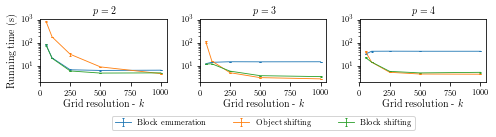

In [87]:
stat = 'time'
fig, ax  = plt.subplots(nrows=1, ncols=3, figsize=figsize(1.0, ratio=.4))
fig.subplots_adjust(bottom=0.10, left=0.10)
for i in [2, 3, 4]:
    ax = plt.subplot(1, 3, i -1)
    dataset_dict = cov_results['covertype']
    for sparsifier in sparsifiers:
        gridRes = map(lambda x: int(x), [x for x in dataset_dict[serialize(sparsifier)].keys() if dataset_dict[serialize(sparsifier)][x][str(i)]['status'] == 'successful'])
        gridRes.sort()
        if stat in dataset_dict[serialize(sparsifier)][str(gridRes[0])][str(i)]:
            plt.errorbar(gridRes, [np.mean(dataset_dict[serialize(sparsifier)][str(x)][str(i)][stat]) for x in gridRes], yerr=[np.std(dataset_dict[serialize(sparsifier)][str(x)][str(i)][stat]) for x in gridRes], label=alg_names[serialize(sparsifier)], capsize=1, linewidth=0.85)
    if i == 2:
        plt.ylabel(ylabel[stat])
    plt.title('$p = %d$' % i)
    plt.xlabel('Grid resolution - $k$')
    if ylog[stat]:
        plt.yscale('log')
    ax.set_ylim([2, 1050])
plt.subplot(1, 3, 2)
lgd = plt.legend(bbox_to_anchor=(-0.7, -0.75, 2.4, .35), loc=8,
   ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()
savefig('../plots/covtype_time', bbox_extra_artists=(lgd,), bbox_inches='tight')